## Specific expectations for the proposal (DELETE BEFORE SUBMISSION):
Each group is expected to prepare a 1 page (max 500 words) written proposal that identifies the dataset they plan to work on, as well as the question they would like to answer using that dataset for their group project. The proposal should be done in a Jupyter notebook, and then submitted both as an .html file (File -> Download As -> HTML) and an .ipynb file that is reproducible (i.e. works and runs without any additional files.)

## **Introduction**

Heart disease refers to a general group of conditions that affect the heart. As heart disease is one of the leading causes of death in North America, (early) diagnosis is crucial to help save lives. As chest pain type is linked to heart disease type, classifying the type of chest pain a patient exhibits would be an effective way to explore the type of heart disease the patient is suffering from. Using patients' recorded health data, we will be classifying chest pain into one of three categories (anginal, non-anginal, or asymptomatic) in order to answer the question: How are resting blood pressure, age, and maximum heart rate achieved related to a patient's chest pain type, and how accurately can a patient's chest pain type be predicted with these variables? We are using the Heart Disease dataset, containing observations linked to heart conditions, to answer our question. The overall dataset includes data from Cleveland, Hungary, Switzerland, and the VA Long Beach. We have combined all regional data into a single data frame to answer our question. 

#### **Abbreviations**
- **KNN:** K-nearest neighbours

## **Preliminary Exploratory Data Analysis**

The summary table created in this section summarizes the average values of our chosen predictors grouped by chest pain type (the class we are trying to predict). Two preliminary visualizations of the training set were created. One is the count of each class, and the other illustrates the relationship between our two predictor variables. Using a bar graph, the count of observations in each class was effectively shown. The graph allowed us to detect any class imbalances in order to preprocess the data appropriately. The scatterplot depicted the the relationship between two predictor variables..........


In [97]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

In [98]:
options(repr.plot.width = 8, repr.plot.height = 8)

sws_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.switzerland.data"
clv_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.cleveland.data"
hgr_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.hungarian.data"
vlb_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.va.data"

cols <- c("age", "sex", "cp_type", "rest_bp", "cholesterol", "fbs", "rest_ecg", "max_hr",
          "exercise_angina", "st_depression", "st_slope", "coloured_vsls", "thal", "heart_disease")
na_vals <- c("", "NA", "?", -9.0)

sws <- read_csv(sws_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Switzerland")
clv <- read_csv(clv_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Cleveland")
hgr <- read_csv(hgr_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Hungary")
vlb <- read_csv(vlb_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "VA Long Beach")

heart_disease_data <- bind_rows(sws, clv, hgr, vlb)

heart_disease_data$sex <- ifelse(heart_disease_data$sex == 0, "female", "male")
heart_disease_data$cp_type <- ifelse(heart_disease_data$cp_type == 1, "anginal",
                                     ifelse(heart_disease_data$cp_type == 2, "anginal",
                                            ifelse(heart_disease_data$cp_type == 3, "non-anginal", "asymptomatic")))
heart_disease_data$rest_ecg <- ifelse(heart_disease_data$rest_ecg == 0, "normal",
                                      ifelse(heart_disease_data$rest_ecg == 1, "abnormality", "hypertrophy"))
heart_disease_data$exercise_angina <- ifelse(heart_disease_data$exercise_angina == 0, "no", "yes")
heart_disease_data$st_slope <- ifelse(heart_disease_data$st_slope == 1, "upsloping",
                                      ifelse(heart_disease_data$st_slope == 2, "flat", "downsloping"))
heart_disease_data$thal <- ifelse(heart_disease_data$thal == 3, "normal",
                                      ifelse(heart_disease_data$thal == 6, "fixed", "reversable"))

heart_disease_data <- heart_disease_data |> mutate(sex = as.factor(sex), cp_type = as.factor(cp_type), fbs = as.factor(fbs), rest_ecg = as.factor(rest_ecg),
                                                   exercise_angina = as.factor(exercise_angina), st_slope = as.factor(st_slope), thal = as.factor(thal),
                                                   heart_disease = as.factor(heart_disease), location = as.factor(location))

head(heart_disease_data)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
38,female,asymptomatic,105,0,NA,normal,166,no,2.8,upsloping,NA,NA,2,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland


In [99]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = cp_type)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_train)
head(heart_disease_test)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
53,male,anginal,120,0,0,normal,95,no,0.0,flat,NA,normal,3,Switzerland
53,male,anginal,130,0,NA,abnormality,120,no,0.7,downsloping,NA,NA,0,Switzerland
55,male,anginal,140,0,NA,abnormality,150,no,0.2,upsloping,NA,NA,0,Switzerland
62,female,anginal,140,0,NA,normal,143,no,0.0,NA,NA,normal,2,Switzerland
62,male,anginal,120,0,NA,hypertrophy,134,no,-0.8,flat,2,NA,1,Switzerland


age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
43,male,asymptomatic,115,0,0,normal,145,yes,2.0,flat,NA,reversable,4,Switzerland
46,male,asymptomatic,115,0,0,normal,113,yes,1.5,flat,NA,reversable,1,Switzerland
47,male,asymptomatic,110,0,NA,abnormality,149,no,2.1,upsloping,NA,NA,2,Switzerland
50,male,asymptomatic,115,0,0,normal,120,yes,0.5,flat,NA,fixed,3,Switzerland


In [100]:
num_cases_tbl <- count(heart_disease_train, cp_type, name = "num_cases")

cp_type_summarize <- heart_disease_train |> group_by(cp_type) |>
                        summarize(avg_rest_bp = mean(rest_bp, na.rm = TRUE), avg_max_hr = mean(max_hr, na.rm = TRUE),
                                  avg_age = mean(age, na.rm = TRUE), rows = sum(!complete.cases(heart_disease_data)))
                                                                            #how to only look at rows missing data from the current group??

cp_type_full_summary <- bind_cols(cp_type_summarize, select(num_cases_tbl, num_cases))
cp_type_full_summary

cp_type,avg_rest_bp,avg_max_hr,avg_age,rows,num_cases
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>
anginal,131.8896,148.8961,51.06061,621,165
asymptomatic,132.4109,130.1490,54.67473,621,372
non-anginal,129.5786,143.7872,53.24837,621,153


As can be observed from the above table, there are distinct differences in average resting blood pressure, maximum heart rate achieved, and age between the chest pain types (although subtle in some cases). This is a good sign as having multiple predictors with distinct values between classes makes it more likely that we will be able to accurately predict the class of an observation.

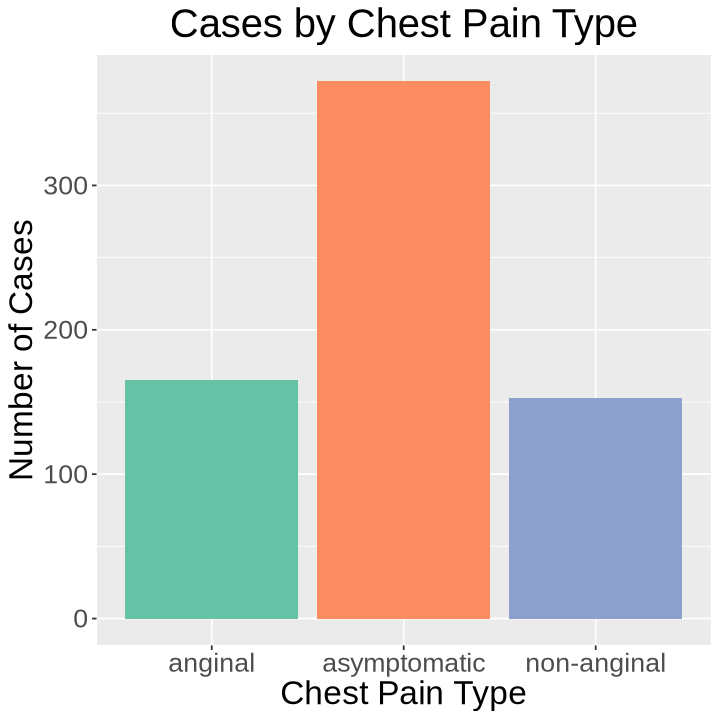

In [101]:
options(repr.plot.width = 6, repr.plot.height= 6)

class_plot <- ggplot(heart_disease_train, aes(x = cp_type, fill = cp_type)) + 
                geom_bar(show.legend = FALSE) +
                labs(x= "Chest Pain Type", y= "Number of Cases") +
                ggtitle("Cases by Chest Pain Type") +
                scale_fill_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
class_plot

The above graph illustrates the imbalance in number of cases of each class. The number of anginal and non-anginal cases are quite similar, however, the number of asymptomatic cases is noteably greater. Individually, the number of aginal and non-anginal cases are about 40%-45% of the asymptomatic cases, thus, although there is an imbalance, it is not devastating.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 46 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 46 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 48 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


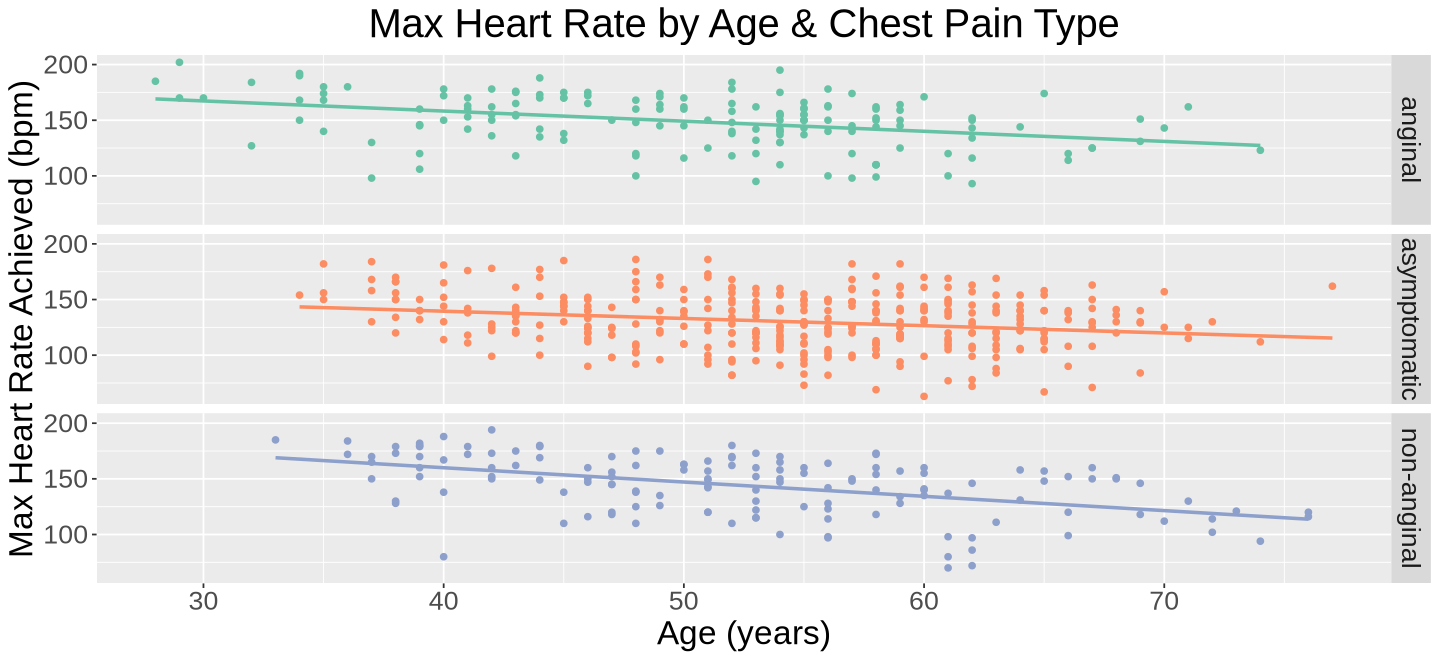

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 48 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


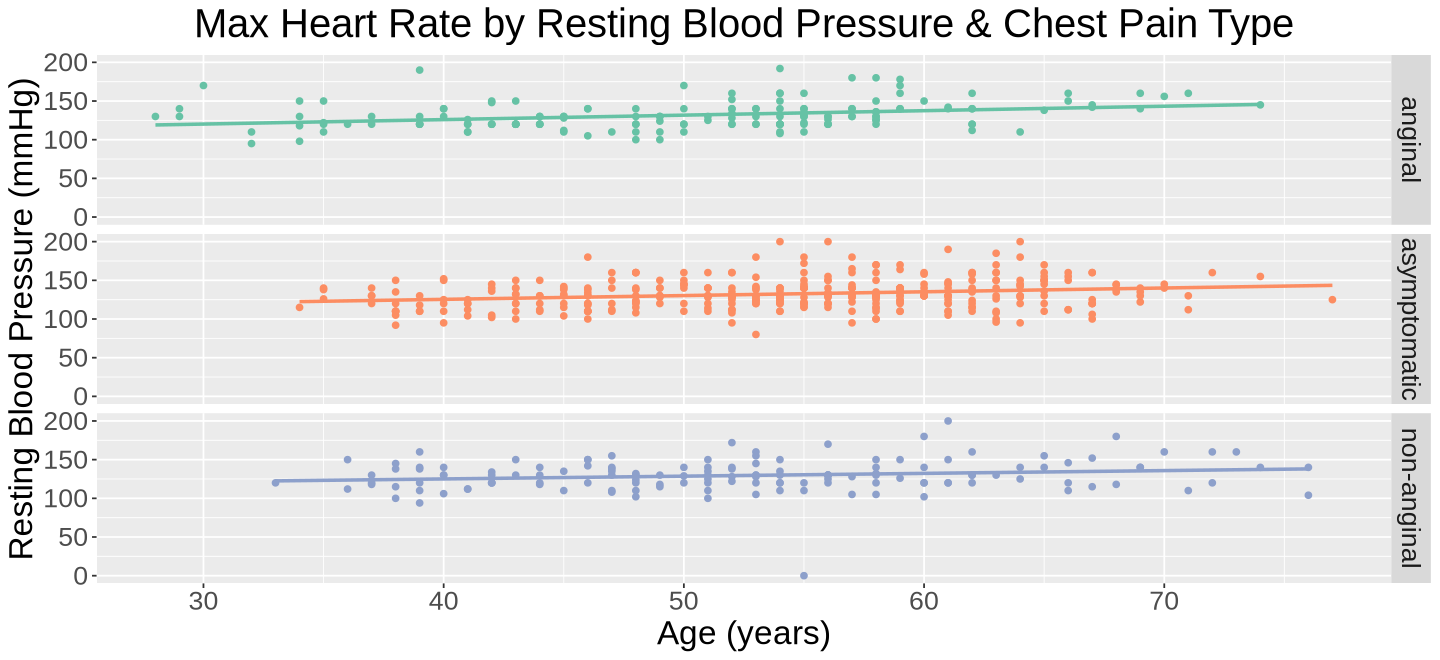

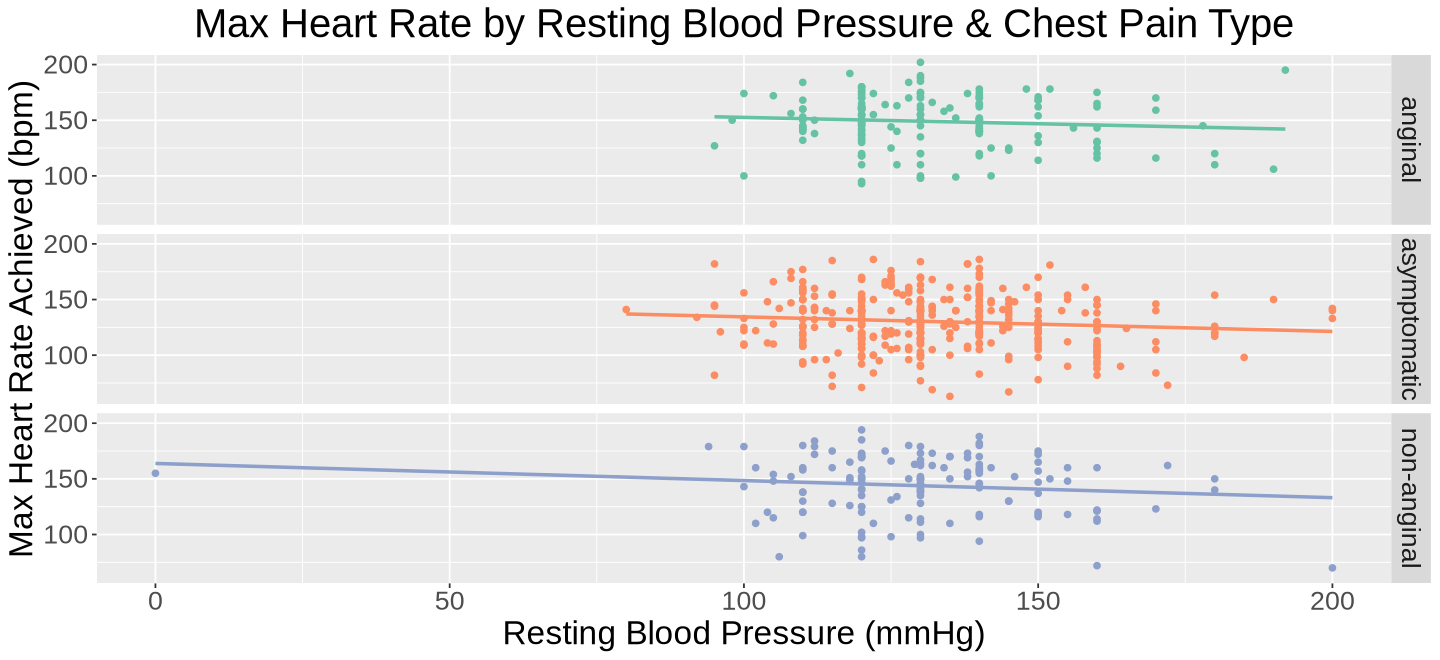

In [102]:
options(repr.plot.width = 12, repr.plot.height = 5.5)

hr_age_plot <- ggplot(heart_disease_train, aes(x = age, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
hr_age_plot

bp_age_plot <- ggplot(heart_disease_train, aes(x = age, y = rest_bp, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
bp_age_plot

hr_bp_plot <- ggplot(heart_disease_train, aes(x = rest_bp, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Resting Blood Pressure (mmHg)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
hr_bp_plot

The above graphs illustrate the relationships between our chosen predictor variables. Within each plot, the trends for each class are quite similar (with some subtle differences as can be seen in the slope of the lines of best fit).

## **Methods**

#### Data Analysis Methods:
Our objective is to classify the type of chest pain that a person is having based on their resting blood pressure, age, and maximum heart rate achieved. The predictor variables were chosen for their variable quantitative characteristics. Our classification will utilize the K-nearest neighbours classification, which encompasses data preprocessing, model training, and class prediction. Given the absence of a distinct chest pain type of interest, the primary performance metric we will use to evaluate our classifier is accuracy rather than precision and recall. To maximize classifier performance by increasing accuracy, we will choose the optimal value for K by tuning our model incorporating cross-validation.


#### Visualizing Our Results:
To visualize how KNN uses distance to classify new observations, we will create scatter plots of our predictor variables with the observation of interest distinctly coloured by class. Then, to show how KNN decides class by majority rule, we will create a bar graph showing the number of the observations of interest's neighbours that belong to each class. To visualize the tuning process, we will produce an accuracy estimate vs. K value line plot, illustrating which K value resulted in the greatest accuracy estimate.

## **Expected Outcomes and Significance**

#### What We Expect to Find:

We expect to find that we can decently accurately predict chest pain type based on age, maximum heart rate achieved, and resting blood pressure. However, we also expect it to be difficult to accurately make these predictions due to the subtlty of the differences between predictor variables. Thus, we expect that we may have lower performance metrics than desired.


#### Potential Impacts Of Our Findings:
Using this classification model, diagnostics of chest pain and heart disease can be improved. Accurate classification of chest pain types may lead to early detection of cardiovascular issues and with timely intervention, healthcare providers can intervene more promptly, potentially preventing or mitigating adverse health events associated with certain chest pain types. Furthermore, improved chest pain classification can help allocate healthcare resources more efficiently by directing attention to patients with higher priority or urgent needs.

#### Questions Which Could Arise From Our Findings:
- What future questions could this lead to?

This could lead questions about classifying chest pain type or even heart disease/condition type based on other easy to get predictors.